# Data Reading and Preprocessing

In [240]:
import pandas as pd
import numpy as np
import time as time
import random
from itertools import combinations
import matplotlib.pyplot as plt  

## Specify the input file here
File needs to be a **csv** of the following format:

```
item1, item2, item3, ... so on
 , t, ...
t, t, t,...
t, t, ...
... so on...```

In [241]:
df = pd.read_csv("groceries_modified.csv", low_memory=False)

In [242]:
df.size

1671950

Indexing each item from the header of the data file.

In [243]:
item_list = list(df.columns)
item_dict = dict()

for i, item in enumerate(item_list):
    item_dict[item] = i + 1

item_dict

{'specialty fat': 1,
 'citrus fruit': 2,
 'soft cheese': 3,
 'cream cheese': 4,
 'cooking chocolate': 5,
 'sausage': 6,
 'cookware': 7,
 'pet care': 8,
 'turkey': 9,
 'dishes': 10,
 'popcorn': 11,
 'whipped/sour cream': 12,
 'pastry': 13,
 'frozen fish': 14,
 'frankfurter': 15,
 'whole milk': 16,
 'ice cream': 17,
 'sound storage medium': 18,
 'other vegetables': 19,
 'sparkling wine': 20,
 'male cosmetics': 21,
 'pudding powder': 22,
 'UHT-milk': 23,
 'candles': 24,
 'liqueur': 25,
 'instant coffee': 26,
 'beef': 27,
 'frozen fruits': 28,
 'artif. sweetener': 29,
 'salt': 30,
 'processed cheese': 31,
 'organic products': 32,
 'snack products': 33,
 'hygiene articles': 34,
 'baking powder': 35,
 'honey': 36,
 'rubbing alcohol': 37,
 'spices': 38,
 'potted plants': 39,
 'herbs': 40,
 'dental care': 41,
 'white wine': 42,
 'chicken': 43,
 'frozen meals': 44,
 'candy': 45,
 'hard cheese': 46,
 'potato products': 47,
 'bottled water': 48,
 'hair spray': 49,
 'liver loaf': 50,
 'nut snack':

Extracting the transactions from the data.

In [244]:
transactions = list()

for i, row in df.iterrows():
    transaction = set()

    for item in item_dict:
        if row[item] == 1:
            transaction.add(item_dict[item])
    transactions.append(transaction)

transactions

[{2, 129, 130, 166},
 {75, 96, 105},
 {16},
 {4, 96, 155, 156},
 {16, 19, 161, 162},
 {16, 68, 96, 103, 146},
 {150},
 {19, 23, 71, 142, 150},
 {39},
 {16, 55},
 {19, 48, 52, 75, 144},
 {2, 10, 16, 48, 68, 73, 75, 96, 108},
 {27},
 {15, 56, 150},
 {43, 75},
 {64, 68, 99, 170},
 {170},
 {157},
 {144},
 {152},
 {19},
 {13, 61},
 {16},
 {4, 31, 64, 75, 84},
 {19, 45, 54, 75, 76, 108, 115, 120, 133, 143, 150},
 {48, 136},
 {96},
 {6, 56, 144, 150},
 {19},
 {56, 64, 69, 106, 136, 170},
 {48, 85, 96, 152},
 {19, 34, 38, 48, 87, 150, 159},
 {16, 19, 85, 99, 115},
 {12, 16, 19, 29, 56, 70, 146, 169},
 {27, 84, 135},
 {13, 56},
 {170},
 {136},
 {16, 19, 115, 122},
 {2, 64, 90},
 {6, 56, 69, 136, 150, 152},
 {13, 16, 45, 55, 56, 75, 96, 98, 99, 105, 106, 115, 133},
 {96, 169},
 {136},
 {4, 48, 56, 61, 64, 96, 107, 150},
 {105},
 {13, 48},
 {150},
 {167},
 {12, 19, 23, 46, 48, 68, 73, 115, 150, 162},
 {6, 64, 131, 150},
 {136},
 {16, 19, 135, 158},
 {9, 19, 35, 73, 75, 98, 106, 130, 166, 170},
 {

---
## Utility Functions

**get_support** function evaluates the support value for a set given all the transactions.

In [245]:
def get_support(transactions, item_set):
    match_count = 0
    for transaction in transactions:
        if item_set.issubset(transaction):
            match_count += 1

    return float(match_count/len(transactions))

---
**self_join** performs join based on the last level valid sets. It joins each sets together by performing union and if the length exceeds the current level, it will skip that set.

In [246]:
def check_constraints(union_set, constraint_list):
    result = True

    for constraint in constraint_list:
        if constraint.issubset(union_set):
            result = False
            break

    return result

In [247]:
def self_join(frequent_item_sets_per_level, level, constraint_list):
    current_level_candidates = list()
    last_level_items = frequent_item_sets_per_level[level - 1]

    if len(last_level_items) == 0:
        return current_level_candidates

    for i in range(len(last_level_items)):
        for j in range(i+1, len(last_level_items)):
            itemset_i = last_level_items[i][0]
            itemset_j = last_level_items[j][0]
            union_set = itemset_i.union(itemset_j)

            if union_set not in current_level_candidates and len(union_set) == level and check_constraints(union_set, constraint_list):
                current_level_candidates.append(union_set)

    return current_level_candidates

---
**pruning** function prunes the candidate sets evaluated after completing the self-join part. For each itemset, it finds all its subsets by dropping a single elements from it and checks if that subset was present in the previous level or not. If that subset was not present in the previous level, then the current set is not valid and must not be used, and is thus pruned.

In [248]:
def get_single_drop_subsets(item_set):
    single_drop_subsets = list()
    for item in item_set:
        temp = item_set.copy()
        temp.remove(item)
        single_drop_subsets.append(temp)

    return single_drop_subsets

def is_valid_set(item_set, prev_level_sets):
    single_drop_subsets = get_single_drop_subsets(item_set)

    for single_drop_set in single_drop_subsets:
        if single_drop_set not in prev_level_sets:
            return False
    return True

def pruning(frequent_item_sets_per_level, level, candidate_set):
    post_pruning_set = list()
    if len(candidate_set) == 0:
        return post_pruning_set

    prev_level_sets = list()
    for item_set, _ in frequent_item_sets_per_level[level - 1]:
        prev_level_sets.append(item_set)

    for item_set in candidate_set:
        if is_valid_set(item_set, prev_level_sets):
            post_pruning_set.append(item_set)

    return post_pruning_set

---
## Apriori Algorithm

In [249]:
from collections import defaultdict

def apriori(min_support, constraint_list):
    frequent_item_sets_per_level = defaultdict(list)
    print("level : 1", end = " ")

    for item in range(1, len(item_list) + 1):
        support = get_support(transactions, {item})
        if support >= min_support:
            frequent_item_sets_per_level[1].append(({item}, support))

    for level in range(2, len(item_list) + 1):
        print(level, end = " ")
        current_level_candidates = self_join(frequent_item_sets_per_level, level, constraint_list)

        post_pruning_candidates = pruning(frequent_item_sets_per_level, level, current_level_candidates)
        if len(post_pruning_candidates) == 0:
            break

        for item_set in post_pruning_candidates:
            support = get_support(transactions, item_set)
            if support >= min_support:
                frequent_item_sets_per_level[level].append((item_set, support))

    return frequent_item_sets_per_level

### Specify the **minimum support** value here

In [250]:
nr_runs = 10
n_samples = 20

In [251]:
min_support = 0.005
start = time.time()
for _ in range(nr_runs):
    sample_list = list()
    constraint_list = list()

    for _ in range(n_samples):
        sample_list.append({random.randint(0, len(item_dict.keys()))})


    for i in range(n_samples):
        for j in range(i+1, n_samples):
            constraint_list.append(sample_list[i].union(sample_list[j]))
    frequent_item_sets_per_level = apriori(min_support, constraint_list)

level : 1 2 

3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 level : 1 2 3 4 5 

Debug print statements to check the number of frequent sets calculated for each level.

In [252]:
for level in frequent_item_sets_per_level:
    print(len(frequent_item_sets_per_level[level]))

120
592
260
12


Debug statement to check the frequent sets calculated.

In [253]:
for level in frequent_item_sets_per_level:
    print(frequent_item_sets_per_level[level])

[({2}, 0.08276563294356888), ({3}, 0.01708185053380783), ({4}, 0.03965429588205389), ({6}, 0.09395017793594305), ({8}, 0.00945602440264362), ({9}, 0.00813421453990849), ({10}, 0.01759023894255211), ({11}, 0.007219115404168785), ({12}, 0.07168276563294357), ({13}, 0.08896797153024912), ({14}, 0.011692933401118455), ({15}, 0.058973055414336555), ({16}, 0.25551601423487547), ({17}, 0.025012709710218607), ({19}, 0.1934926283680732), ({20}, 0.005592272496187087), ({23}, 0.03345195729537367), ({24}, 0.008947635993899338), ({26}, 0.007422470767666497), ({27}, 0.05246568378240976), ({30}, 0.010777834265378749), ({31}, 0.016573462125063547), ({34}, 0.03294356888662939), ({35}, 0.017691916624300967), ({38}, 0.005185561769191663), ({39}, 0.01728520589730554), ({40}, 0.01626842907981698), ({41}, 0.005795627859684799), ({42}, 0.019013726487036097), ({43}, 0.04290798169801729), ({44}, 0.02836807320793086), ({45}, 0.0298932384341637), ({46}, 0.024504321301474327), ({48}, 0.11052364006100661), ({50}, 

---
## Generating Association Rules

Prepare input for calculating association rules: Create a dictionary of each frequent itemset against its support value.

In [254]:
item_support_dict = dict()
item_list = list()

key_list = list(item_dict.keys())
val_list = list(item_dict.values())

for level in frequent_item_sets_per_level:
    for set_support_pair in frequent_item_sets_per_level[level]:
        for i in set_support_pair[0]:
            item_list.append(key_list[val_list.index(i)])
        item_support_dict[frozenset(item_list)] = set_support_pair[1]
        item_list = list()

Debug statement to check the values in the dictionary created.

In [255]:
item_support_dict

{frozenset({'citrus fruit'}): 0.08276563294356888,
 frozenset({'soft cheese'}): 0.01708185053380783,
 frozenset({'cream cheese'}): 0.03965429588205389,
 frozenset({'sausage'}): 0.09395017793594305,
 frozenset({'pet care'}): 0.00945602440264362,
 frozenset({'turkey'}): 0.00813421453990849,
 frozenset({'dishes'}): 0.01759023894255211,
 frozenset({'popcorn'}): 0.007219115404168785,
 frozenset({'whipped/sour cream'}): 0.07168276563294357,
 frozenset({'pastry'}): 0.08896797153024912,
 frozenset({'frozen fish'}): 0.011692933401118455,
 frozenset({'frankfurter'}): 0.058973055414336555,
 frozenset({'whole milk'}): 0.25551601423487547,
 frozenset({'ice cream'}): 0.025012709710218607,
 frozenset({'other vegetables'}): 0.1934926283680732,
 frozenset({'sparkling wine'}): 0.005592272496187087,
 frozenset({'UHT-milk'}): 0.03345195729537367,
 frozenset({'candles'}): 0.008947635993899338,
 frozenset({'instant coffee'}): 0.007422470767666497,
 frozenset({'beef'}): 0.05246568378240976,
 frozenset({'salt

### Utility Function

**find_subset** finds all the subsets of the given itemset.

In [256]:
def find_subset(item, item_length):
    combs = []
    for i in range(1, item_length + 1):
        combs.append(list(combinations(item, i)))

    subsets = []
    for comb in combs:
        for elt in comb:
            subsets.append(elt)

    return subsets

**association_rules** generates the association rules in accordance with the given *minimum confidence* value and the provided dictionary of itemsets against their support values. For itemsets of more than one element, it first finds all their subsets. For every subset A, it calculates the set B = itemset-A. If B is not empty, the confidence of B is calculated. If this value is more than *minimum confidence* value, the rule *A->B* is added to the list.

In [257]:
def association_rules(min_confidence, support_dict):
    rules = list()
    for item, support in support_dict.items():
        item_length = len(item)

        if item_length > 1:
            subsets = find_subset(item, item_length)

            for A in subsets:
                B = item.difference(A)

                if B:
                    A = frozenset(A)

                    AB = A | B

                    confidence = support_dict[AB] / support_dict[A]
                    if confidence >= min_confidence:
                        rules.append((A, B, confidence))

    return rules

### Specify Minimum confidence value here

In [258]:
association_rules = association_rules(min_confidence = 0.6, support_dict = item_support_dict)
filtered_association_rules = []
# # Filter on association rules
# for rule in association_rules:
#     for constraint in constraint_list:
#         if constraint.issubset(rule[0]):
#             filtered_association_rules.append(rule)
end = time.time()
print("\nTime: ", end-start, "sec")


Time:  216.96473169326782 sec


---
### Printing the output in the required format

In [259]:
print("Number of rules: ", len(association_rules), "\n")

for rule in association_rules:
    print('{0}, {1}, <confidence: {2}>'.format(rule[0], rule[1], rule[2]))

Number of rules:  22 

frozenset({'butter', 'whipped/sour cream'}), frozenset({'whole milk'}), <confidence: 0.66>
frozenset({'pip fruit', 'whipped/sour cream'}), frozenset({'whole milk'}), <confidence: 0.6483516483516485>
frozenset({'pip fruit', 'whipped/sour cream'}), frozenset({'other vegetables'}), <confidence: 0.6043956043956045>
frozenset({'butter', 'bottled water'}), frozenset({'whole milk'}), <confidence: 0.6022727272727273>
frozenset({'tropical fruit', 'butter'}), frozenset({'whole milk'}), <confidence: 0.6224489795918368>
frozenset({'butter', 'yogurt'}), frozenset({'whole milk'}), <confidence: 0.6388888888888888>
frozenset({'butter', 'domestic eggs'}), frozenset({'whole milk'}), <confidence: 0.6210526315789474>
frozenset({'butter', 'root vegetables'}), frozenset({'whole milk'}), <confidence: 0.6377952755905512>
frozenset({'tropical fruit', 'curd'}), frozenset({'whole milk'}), <confidence: 0.6336633663366337>
frozenset({'tropical fruit', 'domestic eggs'}), frozenset({'whole mil

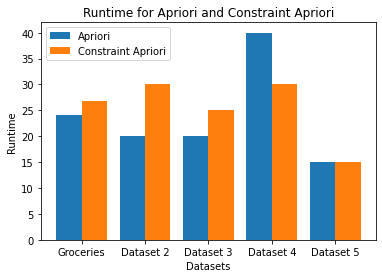

In [260]:
X = ['Groceries','Dataset 2','Dataset 3','Dataset 4','Dataset 5'] 
Apriori_time =              [24.12,    20,     20,     40,     15] 
Constraint_Apriori_time =   [21.70,    30,     25,     30,     15] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, Apriori_time, 0.4, label = 'Apriori') 
plt.bar(X_axis + 0.2, Constraint_Apriori_time, 0.4, label = 'Constraint Apriori') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Datasets") 
plt.ylabel("Runtime") 
plt.title("Runtime for Apriori and Constraint Apriori") 
plt.legend() 
plt.show() 